In [52]:
# impoting the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import sklearn
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
#import mpld3
%matplotlib notebook

#mpld3.enable_notebook()
style.use('ggplot')

In [53]:
# asigning the start date and end date 
start = dt.datetime(1985, 1, 1) # collect from this date
end = dt.datetime.today() #to this date.
stock  = 'AAPL' #using Apple's stock data
df = web.DataReader(stock,'yahoo',start,end) #fetches the data from Yahoo and stores it in data.

In [54]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


In [55]:
df = df.rename(columns = {'Adj Close':'adj_close'})

In [56]:
df.head()

,High,Low,Open,Close,Volume,adj_close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


In [57]:
df.to_csv('AAPL.csv')

In [58]:
data = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)

In [59]:
data.head()

,High,Low,Open,Close,Volume,adj_close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


<IPython.core.display.Javascript object>


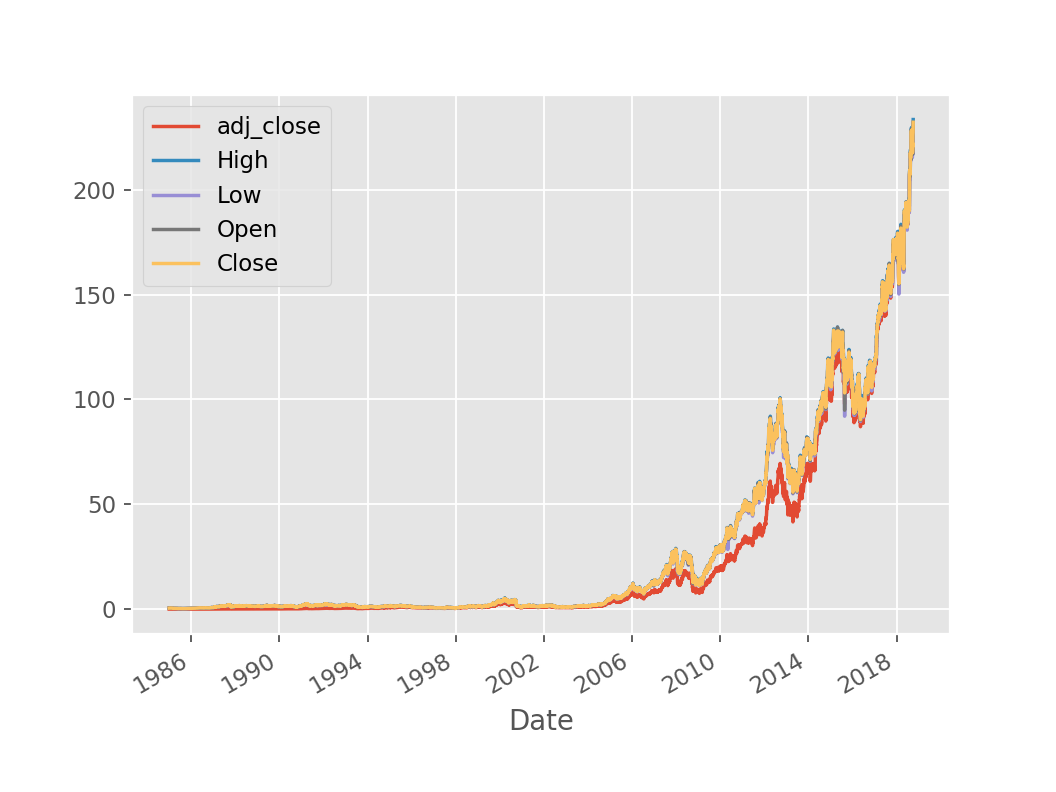

In [60]:
%matplotlib notebook
data[['adj_close','High','Low','Open','Close']].plot()

# Rolling average method.

In [29]:
#creating a new column to add rolling average

#data['100ma'] = data['adj_close'].rolling(window=100).mean()

In [30]:
#data.tail()

In [31]:
#THe first 100 rows cant have the calculation.
#data.head()

In [13]:
#data.dropna(inplace=True)

In [32]:
#the first 100 rows will be deleted due to dropna
#data.head()

In [37]:
#data.tail()

In [38]:
# %matplotlib notebook

# #visualiziation
# ax1 = plt.subplot2grid((6,1), (0,0),rowspan=5,colspan=1)
# ax2 = plt.subplot2grid((6,1), (5,0),rowspan=1,colspan=1, sharex=ax1)

# ax1.plot(data.index,data['adj_close'])
# ax1.plot(data.index,data['100ma'])
# ax2.bar(data.index,data['Volume'])

# plt.show();

# Resampling the data.

In [67]:
data_ohlc=data['adj_close'].resample('10D').ohlc()#creates open high low close
data_volume= data['Volume'].resample('10D').sum()
data_ohlc.head()

,open,high,low,close
Date,,,,
1985-01-02,0.022481,0.024194,0.022481,0.023993
1985-01-12,0.024699,0.024699,0.022682,0.023590
1985-01-22,0.024295,0.024396,0.023388,0.023388
1985-02-01,0.023086,0.024194,0.023086,0.024094
1985-02-11,0.024598,0.024598,0.021271,0.021271


In [68]:
data_ohlc.reset_index(inplace=True)

In [69]:
#candlestick_ohlc requires mdates and ohlc.
data_ohlc['Date'] = data_ohlc['Date'].map(mdates.date2num)


In [70]:
data_ohlc.head()

,Date,open,high,low,close
0,724643.0,0.022481,0.024194,0.022481,0.023993
1,724653.0,0.024699,0.024699,0.022682,0.023590
2,724663.0,0.024295,0.024396,0.023388,0.023388
3,724673.0,0.023086,0.024194,0.023086,0.024094
4,724683.0,0.024598,0.024598,0.021271,0.021271


<IPython.core.display.Javascript object>


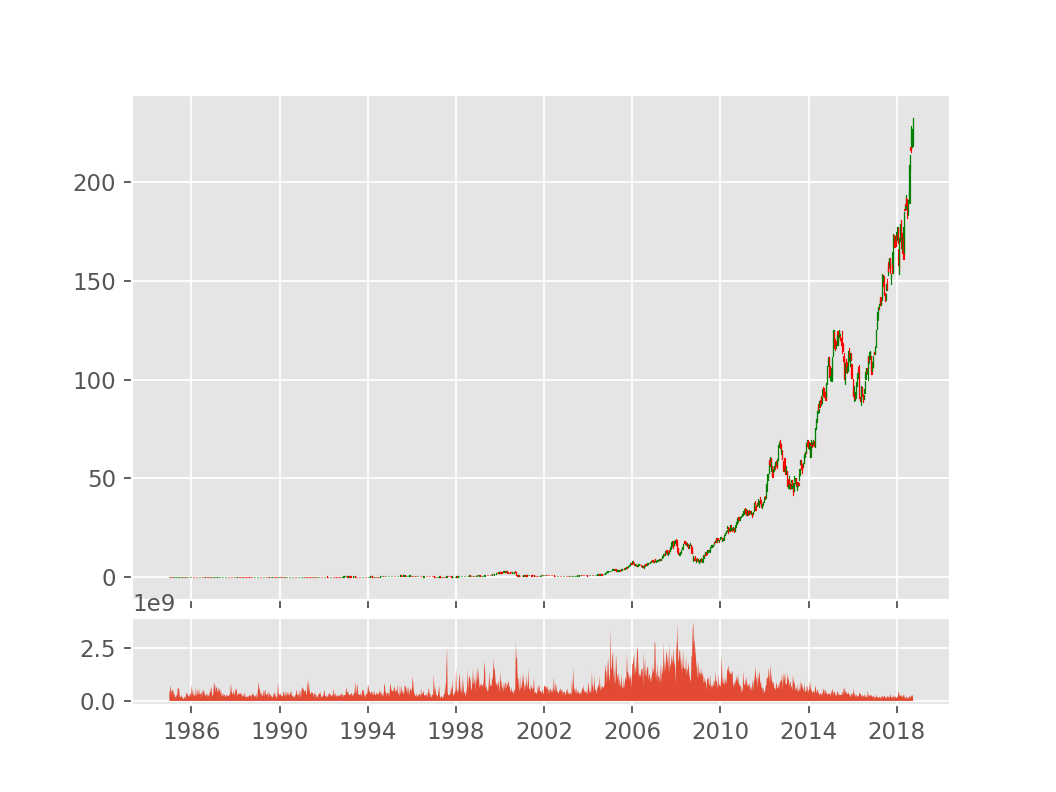

In [74]:
%matplotlib notebook

#visualiziation
ax1 = plt.subplot2grid((6,1), (0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0),rowspan=1,colspan=1, sharex=ax1)
ax1.xaxis_date()#this is to display actual dates in graph

candlestick_ohlc(ax1,data_ohlc.values,width=5,colorup='g')
ax2.fill_between(data_volume.index.map(mdates.date2num),data_volume.values,0)

plt.show();